# Optimizing Online Sports Retail Revenue Project #

 In this notebook, we play the role of a product analyst for an online sports clothing company. The company is specifically interested in how it can improve revenue. We will dive into product data such as pricing, reviews, descriptions, and ratings, as well as revenue and website traffic, to produce recommendations for its marketing and sales teams.

#### The database consists of 5 tables: ####
    1. info
    2. finance
    3. reviews
    4. traffic
    5. brands
#### All tables have a "product_id" column as __PRIMARY KEY__ ####
- - - -

## 1. Setting the required libraries and connections ###

In [107]:
import warnings
warnings.filterwarnings('ignore')

import mysql.connector as connector # To deal with the database
import pandas as pd # to deal with dataframes
import matplotlib.pyplot as plt # for visualizations
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

In [2]:
connection = connector.connect(
    username="mennatallah",
    password="Mmeenna71@SQL",
    port=3306,
    database="sports_store"
)

In [3]:
cursor = connection.cursor()

- - - -

## 2. Creating some functions that will help through the project ##

In [105]:
'''
This function converts the results into pandas dataframe just to simplify its reading
:param columns -> the headers of the results
:param results -> the results themselves
'''

def setting_dataframe(columns, results):
    df = pd.DataFrame(results, columns=columns)
    df = df.style.set_table_styles([{"selector": "td, th", "props": [("border", "1px solid grey !important")]},
                                    {"selector": "th", "props": [('text-align', 'center')]}])
    df = df.set_properties(**{'text-align': 'center'}).hide_index()
    return df

In [68]:
'''
This function simply shows the columns of the table specified
:param table -> the name of the table that you want to show its columns
'''

def show_columns(table):
    cursor.execute("""SHOW COLUMNS FROM {};""".format(table))
    columns = cursor.fetchall()
    print("Columns of {} table are:".format(table))
    number = 1
    for column in columns:
        print(str(number) + ") " + column[0], end="\n")
        number += 1

In [69]:
'''
This function shows the first 10 products of the table specified
:param table -> the name of the table that you want to show its first 10 results
'''

def show_first_ten_results(table):
    cursor.execute("""SELECT * FROM {} ORDER BY product_id LIMIT 10;""".format(table))
    columns = cursor.column_names
    results = cursor.fetchall()
    df = setting_dataframe(columns, results) # To return resutls in the form of a dataframe
    return df

- - - -

## 3. Explore the data stored in the database ##

### 3.1. Show the columns of the tables in the database ###

In [70]:
show_columns("info")

Columns of info table are:
1) product_name
2) product_id
3) description


In [71]:
show_columns("finance")

Columns of finance table are:
1) product_id
2) listing_price
3) sale_price
4) discount
5) revenue


In [72]:
show_columns("reviews")

Columns of reviews table are:
1) product_id
2) rating
3) reviews


In [73]:
show_columns("traffic")

Columns of traffic table are:
1) product_id
2) last_visited


In [74]:
show_columns("brands")

Columns of brands table are:
1) product_id
2) brand


### 3.2. Show top 10 records in each table as dataframe ###

In [106]:
display(show_first_ten_results("info"))

product_name,product_id,description
Air Jordan 12 Retro,130690-017,"An all-time favourite among players and sneakerheads, the Air Jordan 12 Retro features full-length Zoom Air cushioning and full-grain leather styled with distinct radial stitch lines."
Air Jordan OG,133000-106,"First released in '98, the Air Jordan OG was designed for the women's basketball community who wanted an AJ all of their own. The original Air Jordan for women has dimpled leather and midsole sculpting inspired by the AJ13."
Men's Originals Summer Adilette Slippers,280648,"From 72' until now, these adidas Originals Sandals have been a favorite pick amongst the crowd. Quick drying functionality makes it a perfect outdoor as well as an indoor footwear. Distinct designing offers both style and comfort."
Men's Originals Summer Adilette Slides,288022,The adidas Originals Adilette slip ons for men. The Rubber sole keeps your feet in supreme comfort and it comes with 3-Stripes on the upper Synthetic bandage.
Air Jordan 10 Retro,310805-137,"Featuring soft, lightweight cushioning, the Air Jordan 10 Retro offers performance-inspired comfort with iconic Air Jordan detailing."
Air Jordan 7 Retro,313358-006,"The Air Jordan 7 Retro celebrates MJ's championship legacy with a reissue of his 7th game shoe, the one he famously wore to gold-medal glory."
Nike Air Force 1 '07,315115-112,"The radiance lives on in the Nike Air Force 1 '07, the b-ball OG that puts a fresh spin on what you know best: crisp leather in an all-white colourway for a statement look on and off the court."
Nike Air Force 1 '07,315122-001,"Hoops in the park, Sunday BBQs and sunshine. The radiance lives on in the Nike Air Force 1 '07, the b-ball OG that puts a fresh spin on what you know best: crisp leather in an all-black colourway for a statement look on and off the court."
Nike Air Force 1 Mid '07,315123-111,"The legend lives on in the Nike Air Force 1 Mid '07 Men's Shoe, a modern take on the icon that blends classic style and fresh, crisp details."
Nike Air Max 90,325213-139,The Nike Air Max 90 Women's Shoe honours its roots with a supportive upper and the excellent cushioning that made the original a favourite.


In [76]:
display(show_first_ten_results("reviews"))

product_id,rating,reviews
130690-017,4.5,24
133000-106,0.0,0
280648,4.2,54
288022,3.3,95
310805-137,4.7,223
313358-006,4.8,4
315115-112,4.5,67
315122-001,4.5,78
315123-111,4.5,13
325213-139,3.6,5


In [77]:
display(show_first_ten_results("finance"))

product_id,listing_price,sale_price,discount,revenue
130690-017,0.00,159.95,0.00,6909.84
133000-106,0.00,119.95,0.00,0.00
280648,29.99,29.99,0.00,2915.03
288022,29.99,29.99,0.00,5128.29
310805-137,0.00,159.95,0.00,64203.93
313358-006,159.95,111.97,0.00,806.18
315115-112,0.00,74.95,0.00,9038.97
315122-001,0.00,72.95,0.00,10242.18
315123-111,0.00,75.95,0.00,1777.23
325213-139,94.95,75.97,0.00,683.73


In [78]:
display(show_first_ten_results("traffic"))

product_id,last_visited
130690-017,2019-07-29 21:21:00
133000-106,2018-08-21 01:30:00
280648,2019-05-01 00:39:00
288022,2019-10-02 11:04:00
310805-137,2019-07-25 17:17:00
313358-006,2018-10-06 14:02:00
315115-112,2020-02-01 00:48:00
315122-001,2020-03-06 01:08:00
315123-111,2018-10-11 16:29:00
325213-139,2018-07-28 15:17:00


In [79]:
display(show_first_ten_results("brands"))

product_id,brand
130690-017,Nike
133000-106,Nike
280648,Adidas
288022,Adidas
310805-137,Nike
313358-006,Nike
315115-112,Nike
315122-001,Nike
315123-111,Nike
325213-139,Nike


- - - -

## 4. Project Tasks ##

### Task 1: Counting missing values ###

In [80]:
non_missing_records = """
    SELECT COUNT(*) AS total_rows,
        COUNT(I.description) AS count_description,
        COUNT(F.listing_price) AS count_listing_price,
        COUNT(T.last_visited) AS count_last_visited
    FROM info AS I
    INNER JOIN finance AS F
        ON F.product_id = I.product_id
    INNER JOIN traffic AS T
        ON T.product_id = I.product_id;
"""

cursor.execute(non_missing_records)
columns = cursor.column_names
results = cursor.fetchall()
setting_dataframe(columns, results)

total_rows,count_description,count_listing_price,count_last_visited
3179,3179,3179,3179


### Task 2: Nike VS. Adidas pricing ###

In [82]:
prices_in_adidas_vs_nike = """
    SELECT B.brand, FORMAT(F.listing_price, 0) AS listing_price, COUNT(*) AS number_of_products
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    WHERE F.listing_price > 0
    GROUP BY B.brand, F.listing_price
    ORDER BY F.listing_price DESC;
"""

cursor.execute(prices_in_adidas_vs_nike)
columns = cursor.column_names
results = cursor.fetchall()
setting_dataframe(columns, results)

brand,listing_price,number_of_products
Adidas,300,2
Adidas,280,4
Adidas,240,5
Adidas,230,8
Adidas,220,11
Adidas,200,8
Nike,200,1
Adidas,190,7
Nike,190,2
Adidas,180,34


### Task 3: Labeling price ranges ###

In [83]:
pricing_labels = """
    SELECT B.brand, SUM(F.revenue) AS total_revenue,
        CASE
            WHEN F.listing_price < 42 THEN "Budget"
            WHEN F.listing_price >= 42 AND F.listing_price < 74 THEN "Average"
            WHEN F.listing_price >= 74 AND F.listing_price < 129 THEN "Expensive"
            ELSE "Elite"
        END AS price_category
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    WHERE B.brand != ""
    GROUP BY B.brand, price_category
    ORDER BY total_revenue DESC;
"""

cursor.execute(pricing_labels)
columns = cursor.column_names
results = cursor.fetchall()
setting_dataframe(columns, results)

brand,total_revenue,price_category
Adidas,4626980.07,Expensive
Adidas,3233661.06,Average
Adidas,3014316.83,Elite
Adidas,651661.12,Budget
Nike,595341.02,Budget
Nike,128475.59,Elite
Nike,71843.15,Expensive
Nike,6623.50,Average


### Task 4: Average discount by brand ###

In [84]:
discount = """
    SELECT B.brand, CONCAT(ROUND(AVG(F.discount)*100, 2), "%") AS average_discount
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    GROUP BY B.brand
    HAVING B.brand != "";
"""

cursor.execute(discount)
columns = cursor.column_names
results = cursor.fetchall()
setting_dataframe(columns, results)

brand,average_discount
Adidas,33.45%
Nike,0.00%


### Task 5: Correlation between *revenue* and *reviews* ###

In [115]:
correlation = """
    SELECT R.reviews AS number_of_reviews, ROUND(AVG(F.revenue), 2) AS average_revenue
    FROM reviews AS R
    INNER JOIN finance AS F
        ON F.product_id = R.product_id
    GROUP BY number_of_reviews
    ORDER BY number_of_reviews DESC;
"""

cursor.execute(correlation)
columns = cursor.column_names
results = cursor.fetchall()
revenue_reviews = setting_dataframe(columns, results)
display(revenue_reviews)

number_of_reviews,average_revenue
223,64203.93
105,27395.55
99,7391.74
98,8360.92
97,8432.30
96,8717.54
95,7228.17
94,11153.95
93,10339.85
92,7084.17


In [117]:
# 1. Turn df from styler type to dataframe type as it need to be
df = setting_dataframe(columns, results).data
# 2. turn the *revenue*  column into float instead of object(string)
df['average_revenue'] = df['average_revenue'].astype('float')

# 3. Get the correlation coefficient
corr_coeff = df['average_revenue'].corr(df['number_of_reviews'])
print("Correlation coefficient between number of reviews and average revenue is: {}".format(round(corr_coeff, 4)))

Correlation coefficient between number of reviews and average revenue is: 0.8033


(0.0, 15000.0)

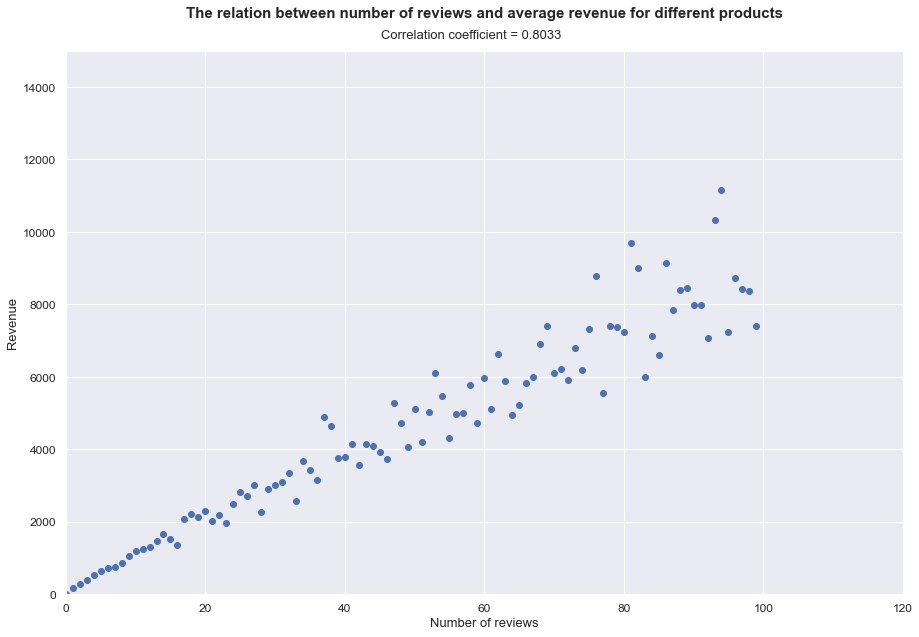

In [174]:
figure = plt.figure(figsize=(15, 10))
plt.scatter(revenue_reviews.data['number_of_reviews'], revenue_reviews.data['average_revenue'])
plt.xlabel("Number of reviews", fontsize=13)
plt.ylabel("Revenue", fontsize=13)
plt.title("The relation between number of reviews and average revenue for different products", y=1.05, fontsize=15, fontweight="bold")
plt.suptitle("Correlation coefficient = {}".format(round(corr_coeff, 4)), y=0.91, fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Some focus
plt.xlim([0,120])
plt.ylim([0,15000])

<div align="center">
    It's obvious now that the more the number of reviews, the more the company gain revenue. Maybe this happens because people trust the products with more reviews than the others.
</div>

### Task 6: Ratings and reviews by product description length ###

In [8]:
description_length = """
    SELECT TRUNCATE(LENGTH(I.description), -2) AS description_length,
        ROUND(AVG(R.rating), 2) AS average_rating
    FROM info AS I
    INNER JOIN reviews AS R
        ON R.product_id = I.product_id
    WHERE description != ""
    GROUP BY description_length
    ORDER BY description_length DESC;
"""

cursor.execute(description_length)
columns = cursor.column_names
results = cursor.fetchall()

setting_dataframe(columns, results)

description_length,average_rating
500,3.39
400,3.32
300,3.29
200,3.27
100,3.21
0,1.87


### Task 7: Reviews by month and brand ###

In [67]:
brands_reviews = """
    SELECT B.brand, MONTH(T.last_visited) AS month, COUNT(R.product_id) AS num_reviews
    FROM brands AS B
    INNER JOIN traffic AS T
        ON T.product_id = B.product_id
    INNER JOIN reviews AS R
        ON R.product_id = B.product_id
    GROUP BY B.brand, month
    HAVING B.brand != "" AND month != ""
    ORDER BY B.brand, month;
"""

cursor.execute(brands_reviews)
columns = cursor.column_names
results = cursor.fetchall()

setting_dataframe(columns, results)

brand,month,num_reviews
Adidas,1,253
Adidas,2,272
Adidas,3,269
Adidas,4,180
Adidas,5,172
Adidas,6,159
Adidas,7,170
Adidas,8,189
Adidas,9,181
Adidas,10,192


### Task 8: Footwear product performance ###

In [111]:
footwear = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )

    SELECT COUNT(*) AS number_of_footwears FROM footwear;
"""

cursor.execute(footwear)
columns = cursor.column_names
results = cursor.fetchall()

df = setting_dataframe(columns, results).data
df

,number_of_footwears
0,2700


In [108]:
# To get the median of total revenue for foatwear

revenue = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )
    
    SELECT revenue FROM finance;
"""

cursor.execute(revenue)
results = cursor.fetchall()

df['median_footwear_revenue'] = np.median(results)

setting_dataframe(df.columns, df)

number_of_footwears,median_footwear_revenue
2700,2653.94


### Task 9: Clothing product performance ###

In [113]:
not_footwear = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )

    SELECT COUNT(*) AS number_of_footwears FROM info
    WHERE description NOT IN (SELECT description FROM footwear);
"""

cursor.execute(not_footwear)
columns = cursor.column_names
results = cursor.fetchall()

df = setting_dataframe(columns, results).data
df

,number_of_footwears
0,479


In [115]:
revenue = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )
    
    SELECT F.revenue FROM finance AS F
    INNER JOIN info AS I
        ON I.product_id = F.product_id
    WHERE I.description NOT IN (SELECT description FROM footwear);
"""

cursor.execute(revenue)
results = cursor.fetchall()

df['median_footwear_revenue'] = np.median(results)

setting_dataframe(df.columns, df)

number_of_footwears,median_footwear_revenue
479,388.37


- - - -

## 5. Insights ##